Section 1: Generative networks 1: variational autoencoders and MNIST characters (20 mins)
Video 1: Normal autoencoders
Video 2: Applying autoencoders
Video 3: Adding the "variational part" of a VAE
Video 4: Practical use of your autoencoder: noise removal


In [1]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

import tensorflow as tf

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("datasets/MNIST_data/", one_hot=True)

# Training Parameters
learning_rate = 0.01
num_steps = 30000
batch_size = 256

display_step = 1000
examples_to_show = 10

# Network Parameters
num_hidden_1 = 256 # 1st layer num features
num_hidden_2 = 128 # 2nd layer num features (the latent dim)
num_input = 784 # MNIST data input (img shape: 28*28)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, num_input])

# Building the encoder
def encoder(x):
    layer_1 = tf.layers.dense(inputs=x, 
                              units=num_hidden_1, 
                              activation=tf.nn.sigmoid)
    layer_2 = tf.layers.dense(inputs=layer_1, 
                              units=num_hidden_2, 
                              activation=tf.nn.sigmoid)
    return layer_2


# Building the decoder
def decoder(x):
    layer_1 = tf.layers.dense(inputs=x, 
                              units=num_hidden_1, 
                              activation=tf.nn.sigmoid)
    layer_2 = tf.layers.dense(inputs=layer_1, 
                              units=num_input, 
                              activation=tf.nn.sigmoid)
    return layer_2

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()
sess = tf.Session()

# Run the initializer
sess.run(init)

# Training
for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)

    # Run optimization op (backprop) and cost op (to get loss value)
    _, l = sess.run([optimizer, loss], feed_dict={X: batch_x})
    # Display logs per step
    if i % display_step == 0 or i == 1:
        print('Step %i: Minibatch Loss: %f' % (i, l))



Extracting datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting datasets/MNIST_data/t10k-labels-idx1-ubyte.gz
Step 1: Minibatch Loss: 0.237415
Step 1000: Minibatch Loss: 0.024357
Step 2000: Minibatch Loss: 0.015406
Step 3000: Minibatch Loss: 0.012110
Step 4000: Minibatch Loss: 0.011266
Step 5000: Minibatch Loss: 0.009602


KeyboardInterrupt: 

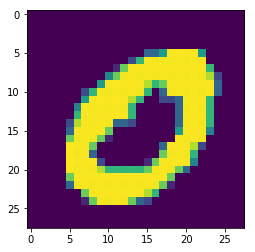

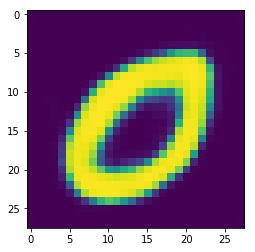

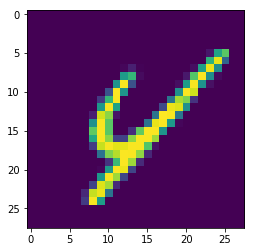

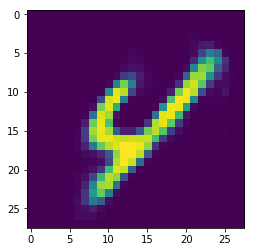

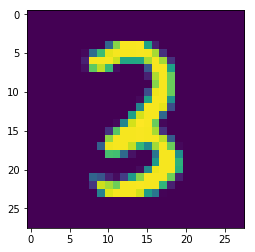

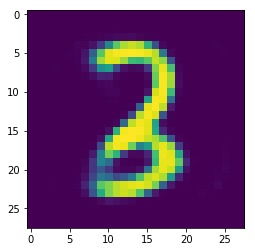

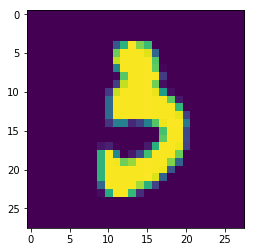

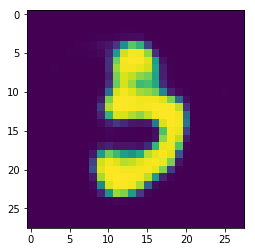

In [8]:

# Encode and decode images from test set and visualize their reconstruction.
batch_x, _ = mnist.test.next_batch(n)
# Encode and decode the digit image
g = sess.run(decoder_op, feed_dict={X: batch_x})
for index in range(n):

    plt.imshow(np.reshape(batch_x[index,:],(28,28)))
    plt.show()
    plt.imshow(np.reshape(g[index,:],(28,28)))
    plt.show()


Section 2: Generative networks 2: generative adversarial networks (20 mins)
Video 1: Building the "adversarial detector" 
Video 2: Generating new images with an adversarial generator
Video 3: Training both networks: a min-max game
Video 4: Improving your GAN: Wasserstein GANs 


Extracting datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


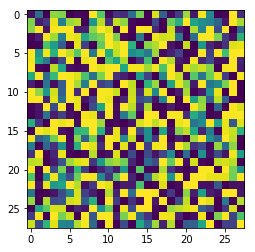

generator_loss:4.446126, decoder_loss:0.593208


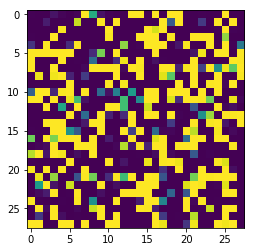

generator_loss:1.830456, decoder_loss:0.183682


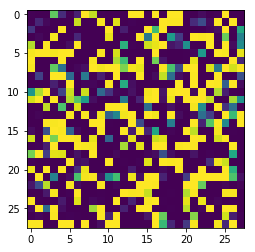

generator_loss:1.818000, decoder_loss:0.178196


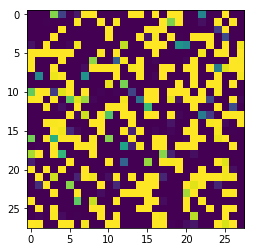

generator_loss:1.821364, decoder_loss:0.178345


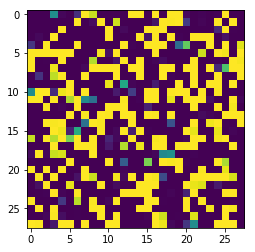

generator_loss:1.830798, decoder_loss:0.177825


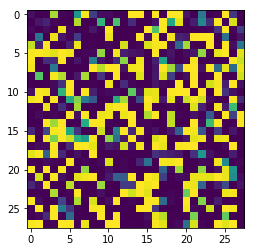

generator_loss:1.827366, decoder_loss:0.177967


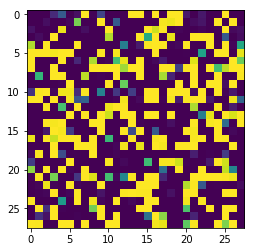

generator_loss:1.829422, decoder_loss:0.177566


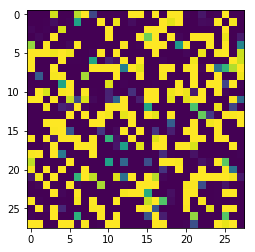

generator_loss:1.829882, decoder_loss:0.178333


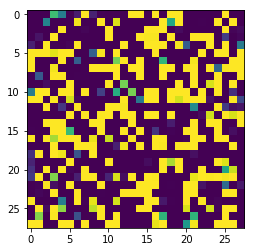

generator_loss:1.828024, decoder_loss:0.178496


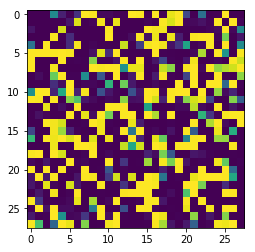

generator_loss:1.825816, decoder_loss:0.177970


In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

data = input_data.read_data_sets("datasets/MNIST_data")
batch_size = 64

'''
  Helper functions for network
'''
def binarize(img):
    return (np.random.uniform(size=img.shape) < img).astype(np.float32)
def get_weights(shape):
    return tf.Variable(tf.truncated_normal(shape=shape, stddev=0.1))
def get_bias(shape):
    return tf.Variable(tf.constant(shape=shape, value=0.1))

def generator(g_input):
    with tf.name_scope('G'):
        l1_size, l2_size = 1200, 1200
        g_w1 = get_weights([28*28, l1_size])
        g_b1 = get_bias([l1_size])
        g_w2 = get_weights([l1_size, l2_size])
        g_b2 = get_bias([l2_size])
        g_w3 = get_weights([l2_size, 28*28])
        g_b3 = get_bias([28*28])

        l1 = tf.nn.relu(tf.add(tf.matmul(X, g_w1), g_b1))
        l2 = tf.nn.relu(tf.add(tf.matmul(l1, g_w2), g_b2))
        logits = tf.sigmoid(tf.add(tf.matmul(l2, g_w3), g_b3))
        return logits
    
class Discriminator():
    def __init__(self):
        with tf.name_scope('D'):
            d_l1_size, d_l2_size = 500, 100
            self.d_w1 = get_weights([28*28, d_l1_size])
            self.d_b1 = get_bias([d_l1_size])
            self.d_w2 = get_weights([d_l1_size, d_l2_size])
            self.d_b2 = get_bias([d_l2_size])
            self.d_w3 = get_weights([d_l2_size, 1])
            self.d_b3 = get_bias([1])

    def network(self, d_input):
        d_l1 = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(d_input, self.d_w1), self.d_b1)), 0.5)
        d_l2 = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(d_l1, self.d_w2), self.d_b2)), 0.5)
        pred = tf.sigmoid(tf.add(tf.matmul(d_l2, self.d_w3), self.d_b3))
        return pred

X = tf.placeholder(shape=[None, 28*28], dtype=tf.float32)
Z = tf.placeholder(shape=[None, 28*28], dtype=tf.float32)

g_z = generator(Z)
decoder = Discriminator()
d_x = decoder.network(X)
d_z = decoder.network(g_z)

g_batch = tf.Variable(0)
d_batch = tf.Variable(0)

g_loss = - tf.reduce_mean(tf.reduce_sum(tf.log(d_z), reduction_indices=[1]))
g_learning_rate = tf.train.exponential_decay(0.01, g_batch, 100, 0.95, staircase=True)
g_optimizer = tf.train.MomentumOptimizer(g_learning_rate, 0.9).minimize(g_loss)

d_loss = - tf.reduce_mean(tf.reduce_sum(tf.log(d_x) + tf.log(1-d_z), reduction_indices=[1]))
d_learning_rate = tf.train.exponential_decay(0.01, g_batch, 100, 0.95, staircase=True)
d_optimizer = tf.train.MomentumOptimizer(d_learning_rate, 0.9).minimize(d_loss)

epochs = 1000
k = 5

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        for j in range(k):
            # NOTE using an arbitary distribution as noise
            batch_z = np.random.normal(0, 0.1, (batch_size,28*28))
            batch_x = binarize(data.train.next_batch(batch_size)[0])
            _, d_l = sess.run([d_optimizer, d_loss], feed_dict={X:batch_x, Z:batch_z})
            
        batch_z = np.random.normal(0, 0.1, batch_size*28*28).reshape((batch_size, 28*28))
        batch_x = data.train.next_batch(batch_size)[0]
        _t, g_l = sess.run([g_optimizer, g_loss], feed_dict={X:batch_x, Z:batch_z})
        if i%100 ==0:

            results = sess.run(g_z, feed_dict={X:batch_x, Z:batch_z})
            plt.imshow(np.reshape(results[0],(28,28)))
            plt.show()
            print("generator_loss:%f, decoder_loss:%f"%(g_l, d_l))
 



Section 3: Deep q-learning with the OpenAI Gym (25 mins)
Video 1:Exploring input and output of different games
Video 2: Random search. Solving your first problem, and joining the leaderboard
Video 3: Reinforcement learning explained: approximating the value function
Video 4: Remembering your actions: adding a replay memory
Video 5: Introduction to the Atari environment



Section 4: Timeseries and recurrent neural networks (20 mins)
Video 1: Dataset: predict stock price - simple RNN
Video 2: Unreasonable effectiveness of LSTMs
Video 3: Comparing LSTM to GRU cell
Video 4: Recurrent neural networks in images and text



Section 5: Learning from only one sample: simple siamese neural networks (15 mins)
Video 1: Discussion on methods with one sample (intro dataset)
Video 2: Defining a good loss function
Video 3: Training and testing your network. 
